# 0.0 Imports

In [1]:
import tensorflow as tf
import json
import string
import gensim
import re
from collections import Counter
import numpy as np
import seaborn as sns
from nltk.stem                          import WordNetLemmatizer
from nltk.corpus                        import stopwords, wordnet
from wordcloud                          import WordCloud
import nltk
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus                        import stopwords, wordnet
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection            import train_test_split
from sklearn.metrics                    import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve

## 0.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

def evaluate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label=0)
    recall = recall_score(y_true, y_pred, pos_label=0)
    f1 = f1_score(y_true, y_pred, pos_label=0)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

def lemmatize_word(word):
    lemma = lemmatizer.lemmatize(word, pos=wordnet.VERB)
    return lemmatizer.lemmatize(lemma, pos=wordnet.NOUN)

def process_text(text):
    #convert do uncased
    text = text.lower()
    
    # Remove Pontuation
    text = ''.join([char for char in text if char not in string.punctuation])
    
    # Tokemnization, lemmatization and stopwords removal
    words = text.split()
    filtered_and_lemmatized_words = [lemmatize_word(word) for word in words if word.lower() not in english_stopwords]
    text = ' '.join(filtered_and_lemmatized_words)
    
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def get_weight_matrix(model, vocab):
    vocab_size = len(vocab) + 1
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    
    for word, i in vocab.items():
        if word in model.wv:
            weight_matrix[i] = model.wv[word]
    
    return weight_matrix

## 0.2 Loading Data

In [3]:
datastore = []
file_path = "../data/Sarcasm_Headlines_Dataset_v2.json"

with open(file_path, 'r') as f:
    for line in f:
        datastore.append(json.loads(line))

sentences = [item['headline'] for item in datastore]
labels = [item['is_sarcastic'] for item in datastore]

In [4]:
df_raw = pd.DataFrame(datastore)

In [5]:
df_raw.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


# 1.0 Data Description

In [6]:
df1 = df_raw.copy()

## 1.1 Data Dimension

In [7]:
print("Número de linhas: {}".format(df1.shape[0]))
print("Número de colunas: {}".format(df1.shape[1]))

Número de linhas: 28619
Número de colunas: 3


## 1.2 Data Types

In [8]:
df1.dtypes

is_sarcastic     int64
headline        object
article_link    object
dtype: object

## 1.3 Check NA

In [9]:
df1.isna().sum()

is_sarcastic    0
headline        0
article_link    0
dtype: int64

## 1.4 Most Used Words

In [10]:
#concatenate all texts in one variable
all_texts = ''.join(df1['headline'])

#Take words
words = all_texts.split()

#Count Words
word_counts = Counter(words)
df_words = pd.DataFrame(word_counts.items(), columns=['word','count'])

In [11]:
df_words.sort_values(by='count', ascending=False).head(10)

,word,count
31,to,8992
5,of,6230
62,in,4420
190,the,4294
93,for,3566
73,a,2818
16,on,2530
216,and,1949
45,with,1920
13,is,1582


### 1.4.1 Sarcastic Titles

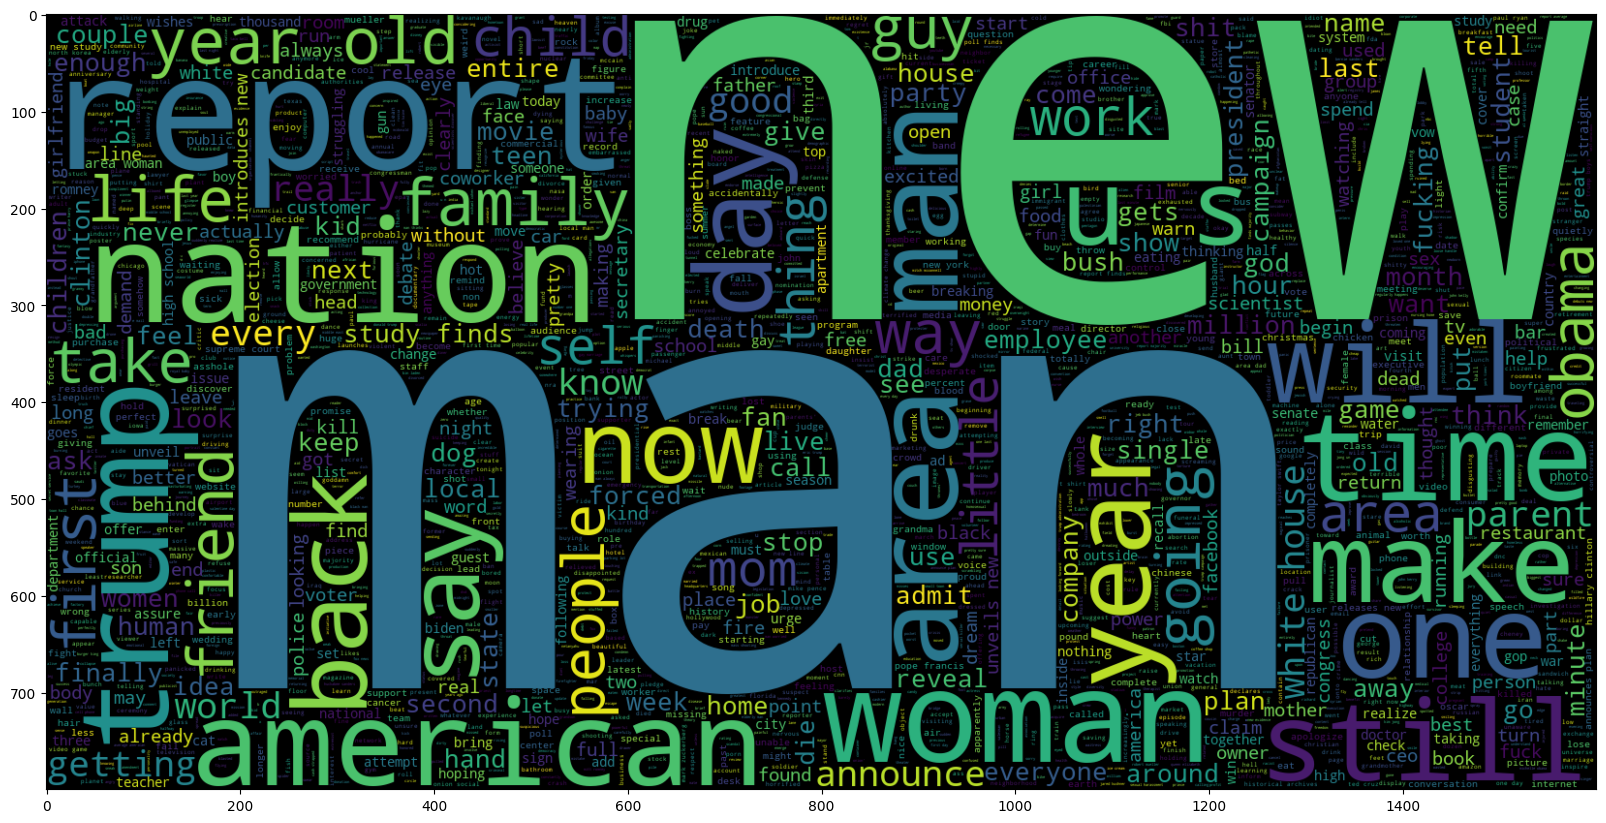

In [12]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df1[df1.is_sarcastic == 1].headline))
plt.imshow(wc , interpolation = 'bilinear')

### 1.4.2 Not Sarcastic Titles

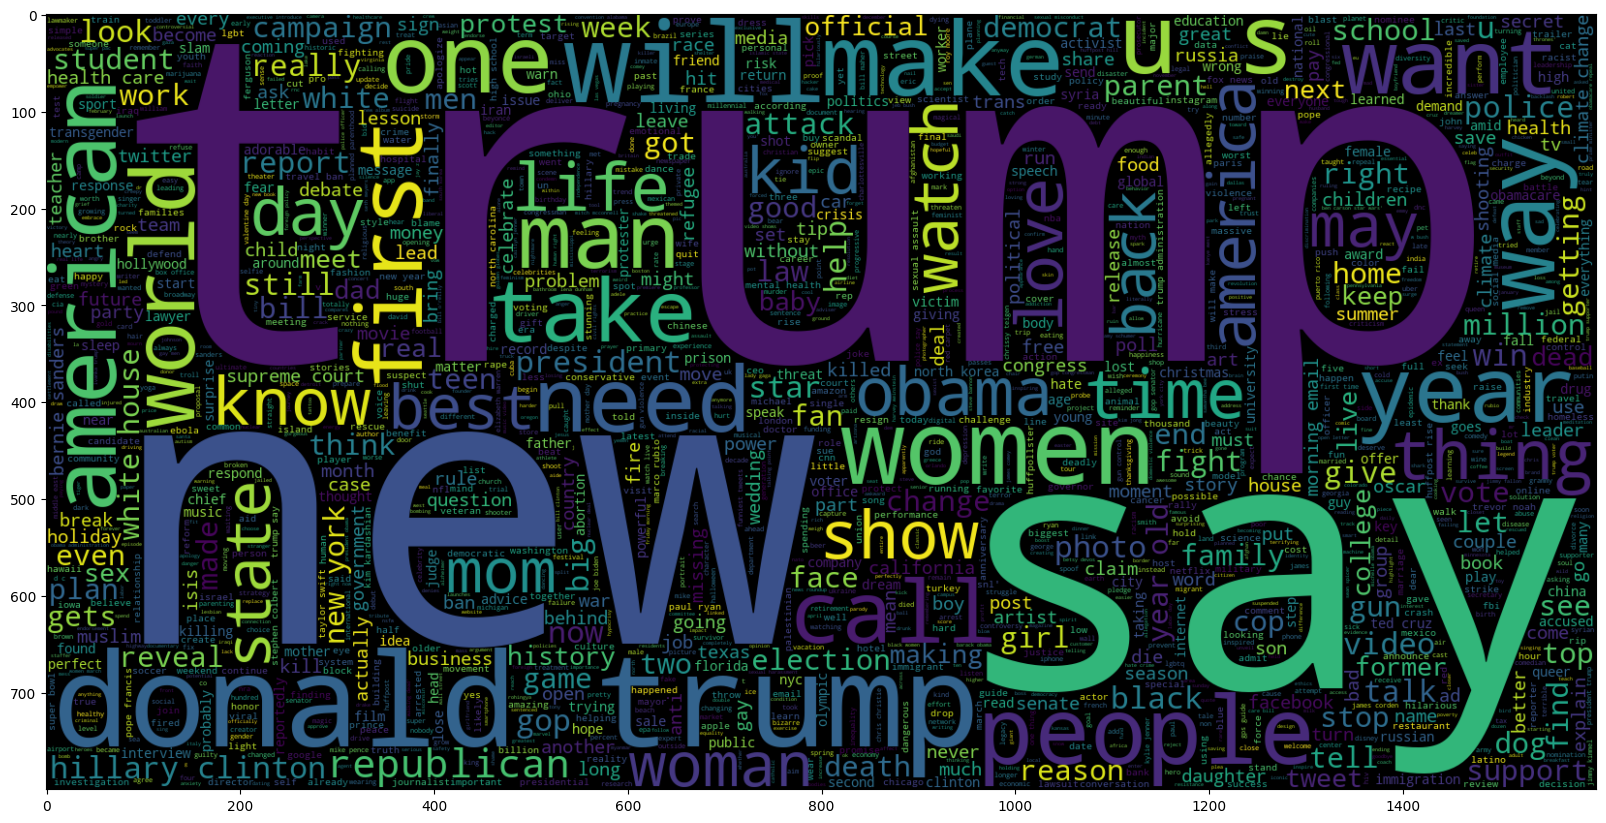

In [13]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df1[df1.is_sarcastic == 0].headline))
plt.imshow(wc , interpolation = 'bilinear')

# 2.0 Text Preprocessing

In [14]:
df2 = df1.copy()

In [15]:
df2['is_sarcastic'].value_counts(normalize=True)

0    0.523603
1    0.476397
Name: is_sarcastic, dtype: float64

## 2.1 Removing StopWords and start Lemmatization

In [16]:
# Download necessary resources for nltk
nltk.download('wordnet')
nltk.download('stopwords')

# Inicialize Lemmatizer and set Stopwords in english
lemmatizer = WordNetLemmatizer()
english_stopwords = set(stopwords.words('english'))

df2['headline'] = df2['headline'].apply(process_text)

[nltk_data] Downloading package wordnet to /Users/luishmq/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/luishmq/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
#concatenate all texts in one variable
all_texts_filtered = ''.join(df2['headline'])

#Take words
words_filtered = all_texts_filtered.split()

#Count Words
word_counts_filtered = Counter(words_filtered)
df_words_filtered = pd.DataFrame(word_counts_filtered.items(), columns=['word','count'])

In [18]:
df_words_filtered.sort_values(by='count', ascending=False).head(10)

,word,count
93,trump,1177
84,new,1135
24,get,922
101,man,848
216,make,753
214,say,649
215,woman,571
363,go,504
165,take,479
306,find,476


# 3.0 Data Preparation

In [19]:
df3 = df2.copy()

df3 = df2[['headline', 'is_sarcastic']]

## 3.1 Split Train-Test

In [30]:
max_length = 512
vocab_size = 10000
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

#training_sentences = sentences[0:training_size]
#testing_sentences = sentences[training_size:]
#training_labels = labels[0:training_size]
#testing_labels = labels[training_size:]

In [31]:
X = df3.drop('is_sarcastic', axis=1)
y = df3['is_sarcastic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## 3.2 Tokenization

In [32]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train['headline'])

training_sequences = tokenizer.texts_to_sequences(X_train['headline'])
training_padded = pad_sequences(training_sequences, maxlen=max_length)

testing_sequences = tokenizer.texts_to_sequences(X_test['headline'])
testing_padded = pad_sequences(testing_sequences, maxlen=max_length)

word_index = tokenizer.word_index

## 3.3 Changing to array

In [33]:
training_padded = np.array(training_padded)
y_train = np.array(y_train)
testing_padded = np.array(testing_padded)
y_test = np.array(y_test)

In [34]:
training_padded

array([[   0,    0,    0, ...,   76, 2296, 2166],
       [   0,    0,    0, ..., 3279,  741, 6096],
       [   0,    0,    0, ..., 1624, 1146, 1035],
       ...,
       [   0,    0,    0, ...,  172, 1540, 1851],
       [   0,    0,    0, ...,  267,  254,    1],
       [   0,    0,    0, ...,  294, 9051,  916]], dtype=int32)

## 3.4 Word2Vec Embedding

In [36]:
training_padded_w2v = [list(map(str, row)) for row in training_padded]

In [37]:
EMBEDDING_DIM = 200

w2v_model = gensim.models.Word2Vec(sentences = training_padded_w2v, vector_size=EMBEDDING_DIM , window = 5 , min_count = 1)

In [38]:
len(w2v_model.wv.key_to_index)

10000

In [39]:
embedding_vectors = get_weight_matrix(w2v_model, word_index)

In [41]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

20465

# 4.0 Training Model

## 4.1 LSTM

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, EMBEDDING_DIM, input_length=max_length, weights=[embedding_vectors], trainable=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 30
history = model.fit(training_padded, y_train, epochs=num_epochs, validation_data=(testing_padded, y_test), verbose=2)

Epoch 1/30
716/716 - 225s - loss: 0.5042 - accuracy: 0.7506 - val_loss: 0.4155 - val_accuracy: 0.8068 - 225s/epoch - 315ms/step
Epoch 2/30


In [29]:
y_pred = model.predict(testing_padded)
y_pred_classes = (y_pred > 0.5).astype(int)
y_pred_classes

179/179 [==============================] - 3s 14ms/step


array([[1],
       [1],
       [0],
       ...,
       [0],
       [1],
       [1]])

# 5.0 Model Performance

## 5.1 Confusion Matrix

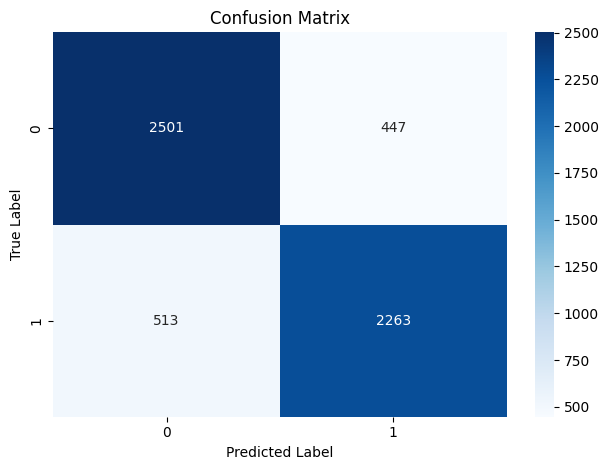

In [30]:
cmatrix = confusion_matrix(y_pred_classes, testing_labels)

sns.heatmap(cmatrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()

## 5.2 ROC Curve

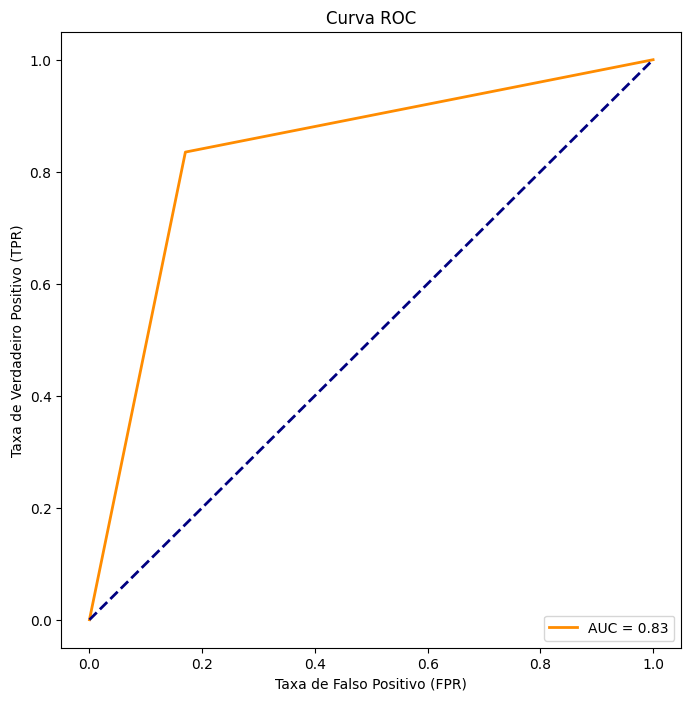

In [36]:
fpr, tpr, thresholds = roc_curve(testing_labels, y_pred_classes)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taxa de Falso Positivo (FPR)')
plt.ylabel('Taxa de Verdadeiro Positivo (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

In [31]:
evaluate_metrics(testing_labels, y_pred_classes)

Accuracy: 0.8323
Precision: 0.8484
Recall: 0.8298
F1 Score: 0.8390


In [32]:
sentence = ['eat your veggies: 9 deliciously different recipes']
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

1/1 [==============================] - 0s 11ms/step
[[1.22483836e-14]]


In [33]:
df1.iloc[3, 1]

'inclement weather prevents liar from getting to work'

In [34]:
df1.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...
